<a href="https://colab.research.google.com/github/kapil0808/Kaggle-first-problem/blob/main/Churn_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import datetime as dt

% matplotlib inline

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Churn Prediction/train_v2.csv',dtype={'is_churn':np.int8})
members = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Churn Prediction/members_v3.csv',parse_dates=['registration_init_time'],dtype={'city':np.int8,'bd':np.int8,
                                                                                         'registered_via':np.int8})
transactions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Churn Prediction/transactions_v2.csv',parse_dates=['transaction_date','membership_expire_date'],
                          dtype={'payment_method_id':np.int8,'payment_plan_days':np.int8,'plan_list_price':np.int8,
                                'actual_amount_paid':np.int8,'is_auto_renew':np.int8,'is_cancel':np.int8})

user_log = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Churn Prediction/user_logs_v2.csv',parse_dates=['date'],dtype={'num_25':np.int16,'num_50':np.int16,
                                    'num_75':np.int16,'num_985':np.int16,'num_100':np.int16,'num_unq':np.int16})

In [4]:
print('Number of rows  & columns',train.shape)
train.head(3)

Number of rows  & columns (970960, 2)


,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1


In [5]:
print('Number of rows  & columns',members.shape)
members.head(3)

Number of rows  & columns (6769473, 6)


,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,2011-09-11
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,2011-09-14
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,2011-09-15


In [6]:
print('Number of rows & columns',transactions.shape)
transactions.head(3)

Number of rows & columns (1431009, 9)


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,42,42,0,2017-01-31,2017-05-04,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,-107,-107,1,2015-08-09,2019-04-12,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,-76,-76,1,2017-03-03,2017-04-22,0


In [7]:
print('Number of rows & columns',user_log.shape)
user_log.head(3)

Number of rows & columns (18396362, 9)


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,2017-03-31,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,2017-03-30,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,2017-03-31,52,3,5,3,84,110,23203.337


In [9]:
print('\nTrain:',train.describe().T)
print('\nMembers:',members.describe().T)
print('\nTransactions:',transactions.describe().T)
print('\nUser log:',user_log.describe().T)


Train:              count      mean       std  min  25%  50%  75%  max
is_churn  970960.0  0.089942  0.286099  0.0  0.0  0.0  0.0  1.0

Members:                     count      mean        std    min  25%  50%   75%    max
city            6769473.0  3.847358   5.478359    1.0  1.0  1.0   4.0   22.0
bd              6769473.0  9.763688  15.354561 -128.0  0.0  0.0  21.0  126.0
registered_via  6769473.0  5.253069   2.361398   -1.0  4.0  4.0   7.0   19.0

Transactions:                         count       mean        std  ...   50%   75%    max
payment_method_id   1431009.0  37.918355   4.964805  ...  40.0  41.0   41.0
payment_plan_days   1431009.0  18.432050  39.830162  ...  30.0  30.0  120.0
plan_list_price     1431009.0 -21.387690  94.768896  ... -76.0  99.0  126.0
actual_amount_paid  1431009.0 -20.556024  94.926916  ... -76.0  99.0  127.0
is_auto_renew       1431009.0   0.785303   0.410612  ...   1.0   1.0    1.0
is_cancel           1431009.0   0.024551   0.154753  ...   0.0   0.0    1.0

In [10]:
train = pd.merge(train,members,on='msno',how='left')
train = pd.merge(train,transactions,how='left',on='msno',left_index=True, right_index=True)
train = pd.merge(train,user_log,how='left',on='msno',left_index=True, right_index=True)

In [11]:
del members,transactions,user_log
print('Number of rows & columns',train.shape)

Number of rows & columns (970960, 23)


In [12]:
train.head(3)

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,2013-12-23,32,90,42,42,0,2017-01-31,2017-05-04,0,2017-03-31,8,4,0,1,21,18,6309.273
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,20.0,male,3.0,2013-12-23,41,30,-107,-107,1,2015-08-09,2019-04-12,0,2017-03-30,2,2,1,0,9,11,2390.699
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,18.0,male,3.0,2013-12-27,36,30,-76,-76,1,2017-03-03,2017-04-22,0,2017-03-31,52,3,5,3,84,110,23203.337


In [13]:
train[['registration_init_time' ,'transaction_date','membership_expire_date','date']].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning an

,registration_init_time,transaction_date,membership_expire_date,date
count,860967,970960,970960,970960
unique,4749,820,1818,31
top,2015-10-09 00:00:00,2017-03-31 00:00:00,2017-04-30 00:00:00,2017-03-30 00:00:00
freq,1575,130414,79283,32331
first,2004-03-26 00:00:00,2015-01-01 00:00:00,2016-04-20 00:00:00,2017-03-01 00:00:00
last,2017-04-24 00:00:00,2017-03-31 00:00:00,2036-10-15 00:00:00,2017-03-31 00:00:00


In [14]:
train[['registration_init_time' ,'transaction_date','membership_expire_date','date']].isnull().sum()

registration_init_time    109993
transaction_date               0
membership_expire_date         0
date                           0
dtype: int64

In [15]:
train['registration_init_time'] = train['registration_init_time'].fillna(value=pd.to_datetime('09/10/2015'))

In [16]:
def date_feature(df):
    
    col = ['registration_init_time' ,'transaction_date','membership_expire_date','date']
    var = ['reg','trans','mem_exp','user_']
    #df['duration'] = (df[col[1]] - df[col[0]]).dt.days 
    
    for i ,j in zip(col,var):
        df[j+'_day'] = df[i].dt.day.astype('uint8')
        df[j+'_weekday'] = df[i].dt.weekday.astype('uint8')        
        df[j+'_month'] = df[i].dt.month.astype('uint8') 
        df[j+'_year'] =df[i].dt.year.astype('uint16') 

date_feature(train)

In [17]:
train.head(5)

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,reg_day,reg_weekday,reg_month,reg_year,trans_day,trans_weekday,trans_month,trans_year,mem_exp_day,mem_exp_weekday,mem_exp_month,mem_exp_year,user__day,user__weekday,user__month,user__year
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.0,28.0,male,3.0,2013-12-23,32,90,42,42,0,2017-01-31,2017-05-04,0,2017-03-31,8,4,0,1,21,18,6309.273,23,0,12,2013,31,1,1,2017,4,3,5,2017,31,4,3,2017
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.0,20.0,male,3.0,2013-12-23,41,30,-107,-107,1,2015-08-09,2019-04-12,0,2017-03-30,2,2,1,0,9,11,2390.699,23,0,12,2013,9,6,8,2015,12,4,4,2019,30,3,3,2017
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.0,18.0,male,3.0,2013-12-27,36,30,-76,-76,1,2017-03-03,2017-04-22,0,2017-03-31,52,3,5,3,84,110,23203.337,27,4,12,2013,3,4,3,2017,22,5,4,2017,31,4,3,2017
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1.0,0.0,NaN,7.0,2014-01-09,36,30,-76,-76,1,2017-03-29,2017-03-31,1,2017-03-31,176,4,2,2,19,191,7100.454,9,3,1,2014,29,2,3,2017,31,4,3,2017,31,4,3,2017
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.0,35.0,female,7.0,2014-01-25,41,30,99,99,1,2017-03-23,2017-04-23,0,2017-03-31,2,1,0,1,112,93,28401.558,25,5,1,2014,23,3,3,2017,23,6,4,2017,31,4,3,2017


In [18]:
train.columns

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_auto_renew',
       'transaction_date', 'membership_expire_date', 'is_cancel', 'date',
       'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq',
       'total_secs', 'reg_day', 'reg_weekday', 'reg_month', 'reg_year',
       'trans_day', 'trans_weekday', 'trans_month', 'trans_year',
       'mem_exp_day', 'mem_exp_weekday', 'mem_exp_month', 'mem_exp_year',
       'user__day', 'user__weekday', 'user__month', 'user__year'],
      dtype='object')

In [19]:
train.isnull().sum()

msno                           0
is_churn                       0
city                      109993
bd                        109993
gender                    582055
registered_via            109993
registration_init_time         0
payment_method_id              0
payment_plan_days              0
plan_list_price                0
actual_amount_paid             0
is_auto_renew                  0
transaction_date               0
membership_expire_date         0
is_cancel                      0
date                           0
num_25                         0
num_50                         0
num_75                         0
num_985                        0
num_100                        0
num_unq                        0
total_secs                     0
reg_day                        0
reg_weekday                    0
reg_month                      0
reg_year                       0
trans_day                      0
trans_weekday                  0
trans_month                    0
trans_year

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970960 entries, 0 to 970959
Data columns (total 39 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   msno                    970960 non-null  object        
 1   is_churn                970960 non-null  int8          
 2   city                    860967 non-null  float64       
 3   bd                      860967 non-null  float64       
 4   gender                  388905 non-null  object        
 5   registered_via          860967 non-null  float64       
 6   registration_init_time  970960 non-null  datetime64[ns]
 7   payment_method_id       970960 non-null  int8          
 8   payment_plan_days       970960 non-null  int8          
 9   plan_list_price         970960 non-null  int8          
 10  actual_amount_paid      970960 non-null  int8          
 11  is_auto_renew           970960 non-null  int8          
 12  transaction_date        970960

In [22]:
col = [ 'city', 'bd', 'gender', 'registered_via']
def missing(df,columns):
    col = columns
    for i in col:
        df[i].fillna(df[i].mode()[0],inplace=True)

missing(train,col)

In [23]:
def unique_value(df):
    col = df.columns
    for i in col:
        print('Number of unique value in {} is {}'.format(i,df[i].nunique()))

unique_value(train)

Number of unique value in msno is 970960
Number of unique value in is_churn is 2
Number of unique value in city is 21
Number of unique value in bd is 186
Number of unique value in gender is 2
Number of unique value in registered_via is 5
Number of unique value in registration_init_time is 4749
Number of unique value in payment_method_id is 37
Number of unique value in payment_plan_days is 30
Number of unique value in plan_list_price is 44
Number of unique value in actual_amount_paid is 47
Number of unique value in is_auto_renew is 2
Number of unique value in transaction_date is 820
Number of unique value in membership_expire_date is 1818
Number of unique value in is_cancel is 2
Number of unique value in date is 31
Number of unique value in num_25 is 361
Number of unique value in num_50 is 179
Number of unique value in num_75 is 94
Number of unique value in num_985 is 218
Number of unique value in num_100 is 586
Number of unique value in num_unq is 430
Number of unique value in total_se

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'The subscription within 30 days of expiration')

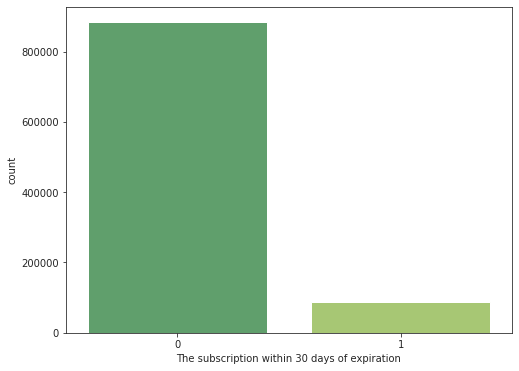

In [24]:
plt.figure(figsize=(8,6))
sns.set_style('ticks')
sns.countplot(train['is_churn'],palette='summer')
plt.xlabel('The subscription within 30 days of expiration')

[ 5. 13.  1. 22.  9. 12.  6. 14.  4. 15. 18.  3. 21.  8.  7. 17. 11. 10.
 20. 16. 19.]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Payment_method_id')

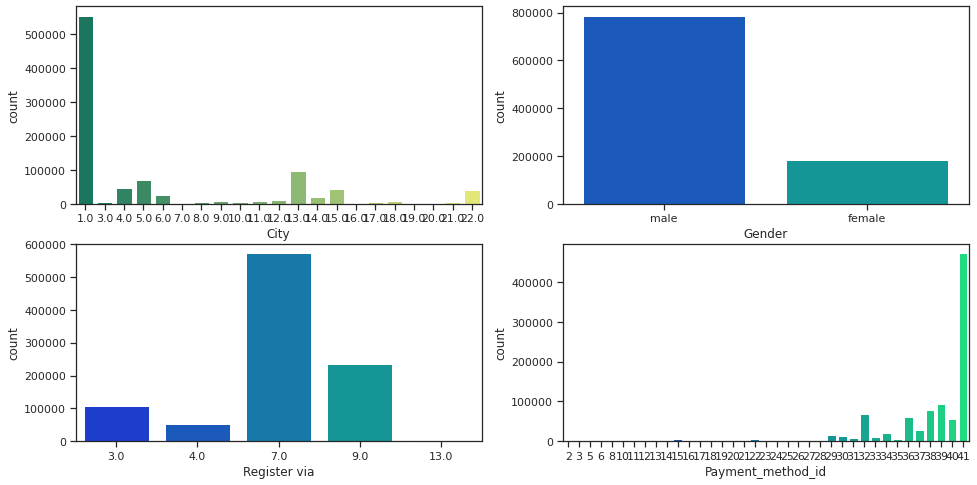

In [26]:
print(train['city'].unique())
fig,ax = plt.subplots(2,2,figsize=(16,8))
ax1,ax2,ax3,ax4 = ax.flatten()


sns.set(style="ticks")
sns.countplot(train['city'],palette='summer',ax=ax1)


ax1.set_xlabel('City')


sns.countplot(x='gender',data = train,palette='winter',ax=ax2)
ax2.set_xlabel('Gender')

sns.countplot(x='registered_via',data=train,palette='winter',ax=ax3)
ax3.set_xlabel('Register via')

sns.countplot(x='payment_method_id',data= train,palette='winter',ax=ax4)
ax4.set_xlabel('Payment_method_id')

In [27]:
print(train['bd'].describe())

count    970960.000000
mean         11.941948
std          15.811148
min        -128.000000
25%           0.000000
50%           0.000000
75%          26.000000
max         126.000000
Name: bd, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of birth day')

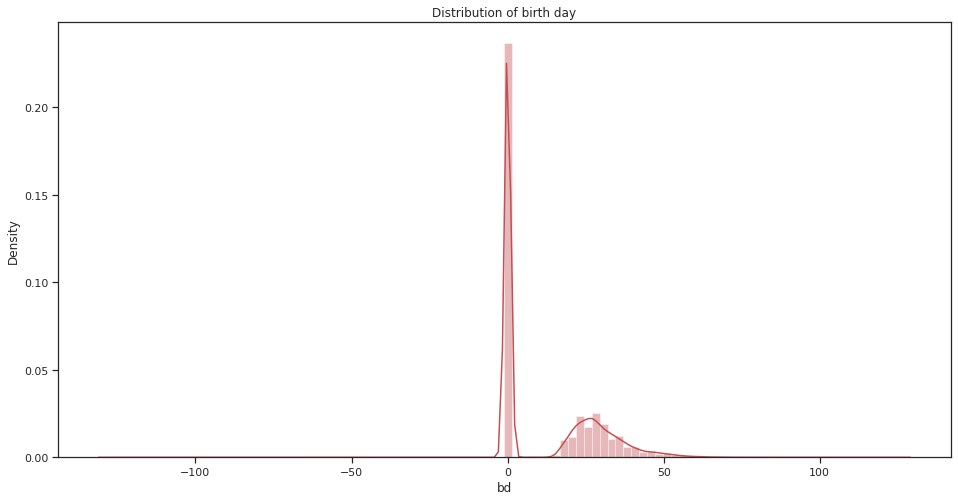

In [39]:
fig,ax = plt.subplots(1,1,figsize=(16,8))
sns.set_style('ticks')
sns.distplot(train['bd'].fillna(train['bd'].mode()[0]),bins=100,color='r',ax=ax)
ax.set_title('Distribution of birth day')

In [40]:
print(pd.crosstab(train['is_churn'],train['gender']))

gender    female    male
is_churn                
0         160404  723226
1          23940   63390


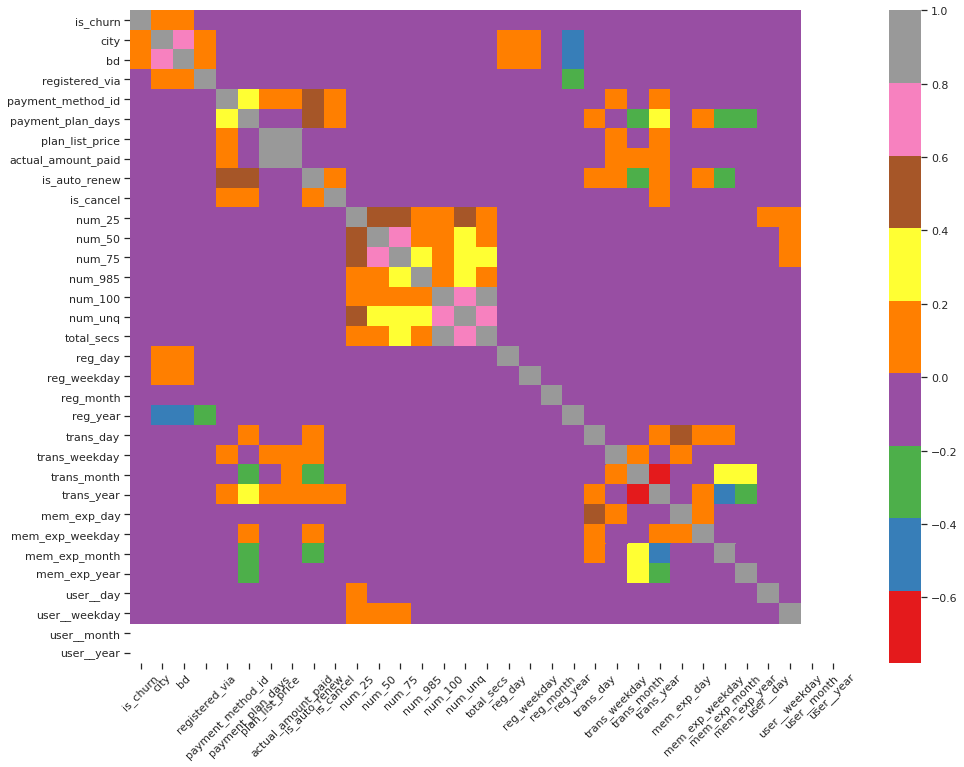

In [41]:
cor = train.corr()
plt.figure(figsize=(16,12))
sns.heatmap(cor,cmap='Set1',annot=False)
plt.xticks(rotation=45);

In [44]:
le = LabelEncoder()
train['gender'] = le.fit_transform(train['gender'])

In [45]:
def OHE(df):
    #col = df.select_dtypes(include=['category']).columns
    col = ['city','gender','registered_via']
    print('Categorical columns in dataset',col)
    
    c2,c3 = [],{}
    for c in col:
        if df[c].nunique()>2 :
            c2.append(c)
            c3[c] = 'ohe_'+c
    
    df = pd.get_dummies(df,columns=c2,drop_first=True,prefix=c3)
    print(df.shape)
    return df
train1 = OHE(train)

Categorical columns in dataset ['city', 'gender', 'registered_via']
(970960, 61)


In [46]:
train1.columns

Index(['msno', 'is_churn', 'bd', 'gender', 'registration_init_time',
       'payment_method_id', 'payment_plan_days', 'plan_list_price',
       'actual_amount_paid', 'is_auto_renew', 'transaction_date',
       'membership_expire_date', 'is_cancel', 'date', 'num_25', 'num_50',
       'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs', 'reg_day',
       'reg_weekday', 'reg_month', 'reg_year', 'trans_day', 'trans_weekday',
       'trans_month', 'trans_year', 'mem_exp_day', 'mem_exp_weekday',
       'mem_exp_month', 'mem_exp_year', 'user__day', 'user__weekday',
       'user__month', 'user__year', 'ohe_city_3.0', 'ohe_city_4.0',
       'ohe_city_5.0', 'ohe_city_6.0', 'ohe_city_7.0', 'ohe_city_8.0',
       'ohe_city_9.0', 'ohe_city_10.0', 'ohe_city_11.0', 'ohe_city_12.0',
       'ohe_city_13.0', 'ohe_city_14.0', 'ohe_city_15.0', 'ohe_city_16.0',
       'ohe_city_17.0', 'ohe_city_18.0', 'ohe_city_19.0', 'ohe_city_20.0',
       'ohe_city_21.0', 'ohe_city_22.0', 'ohe_registered_via_4.0',
 

In [47]:
unwanted = ['msno','is_churn','registration_init_time','transaction_date','membership_expire_date','date']

X = train1.drop(unwanted,axis=1)
y = train1['is_churn'].astype('category')

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state = 10)

In [51]:
lr = LogisticRegression(class_weight='balanced',C=1)
lr.fit(X_train,y_train)
y_pred = lr.predict_proba( X_test)[:,1]
lr.score(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.626995962758507

Text(0, 0.5, 'True positive rate')

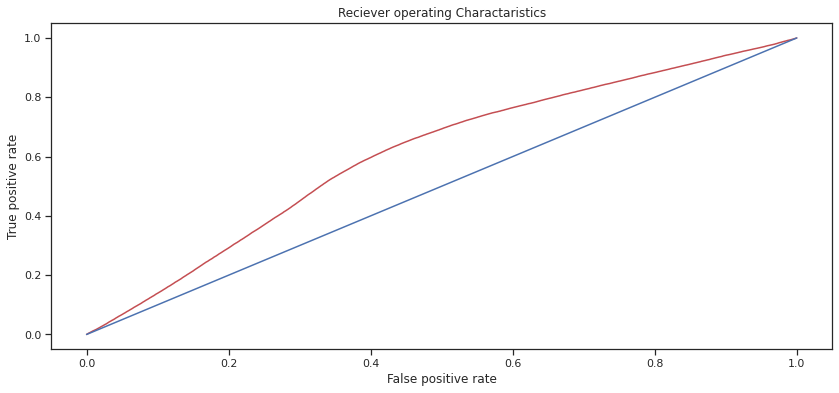

In [52]:
y_proba = lr.predict_proba(X)[:,1]
fpr,tpr,th = roc_curve(y,y_proba)

plt.figure(figsize=(14,6))
plt.plot(fpr,tpr,color='r')
plt.plot([0,1],[0,1],color='b')
plt.title('Reciever operating Charactaristics')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')